## Daten vorbereiten

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


def fetch_dataset(path):
    images = []
    labels = []
    for dir1 in os.listdir(path):
        for file in os.listdir(os.path.join(path,dir1)):
            image_path = os.path.join(path,dir1,file)
            with Image.open(image_path).convert('L') as img:
                arr = np.array(img.getdata()).reshape(256, 256, 1) / 255
                images.append(arr)
                labels.append(dir1)
    
    unique_labels = {k: v for v,k in enumerate(np.unique(labels))}
    numeric_labels = [unique_labels[labels[i]] for i in range(len(labels))]
    #print(numeric_labels)
    return np.array(images),numeric_labels
    # CHANGE STRING LABELS TO NUMERIC VALUES!!
    
def fetch_sampledata(path):
    images = []
    labels = []
    for dir1 in os.listdir(path):
        for file in os.listdir(os.path.join(path,dir1)):
            image_path = os.path.join(path,dir1,file)
            with Image.open(image_path).convert('L') as img:
                arr = np.array(img.getdata()).reshape(64, 64, 1) / 255
                images.append(arr)
                labels.append(dir1)
    
    unique_labels = {k: v for v,k in enumerate(np.unique(labels))}
    numeric_labels = [unique_labels[labels[i]] for i in range(len(labels))]
    #print(numeric_labels)
    return np.array(images),numeric_labels
    # CHANGE STRING LABELS TO NUMERIC VALUES!!

def plot_samples(images,labels):
    fig, axes = plt.subplots(1,4,figsize=(12, 7))
    labels_unique = []
    j = 0
    for i,label in enumerate(labels):
        if (label in labels_unique):
            continue
        labels_unique.append(label)
        ax = axes[j]
        ax.imshow(images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("Category " + str(label))
        j+=1

In [2]:
train_path = os.path.join("data","train")
test_path = os.path.join("data","test")
val_path = os.path.join("data","val")
sample_path = os.path.join("data","sample")

X_train,y_train = fetch_dataset(train_path)
#x_test,y_test = fetch_dataset(test_path)
X_test,y_test = fetch_dataset(val_path)
#x_sample,y_sample = fetch_sampledata(sample_path)


# print("Training Data")
# plot_samples(x_train,y_train)
# print("Testing Data")
# plot_samples(x_test,y_test)
# print("Validation Data")
# plot_samples(x_val,y_val)
#print("Sample Data")
#plot_samples(x_sample,y_sample)


In [7]:
# from sklearn.model_selection import train_test_split
# import random

# X_train, X_test = train_test_split(x_sample, train_size=0.90, test_size=0.10)
# y_train_classes, y_test_classes = train_test_split(y_sample, train_size=0.90, test_size=0.10)


y_train_classes = y_train
y_test_classes = y_test
y_train = tf.keras.utils.to_categorical(y_train_classes, 4)
y_test = tf.keras.utils.to_categorical(y_test_classes, 4)



In [8]:
classes = ["COVID", "HEALTHY", "PNEUMONIA_BAC", "PNEUMONIA_VIR"]

## Daten prüfen

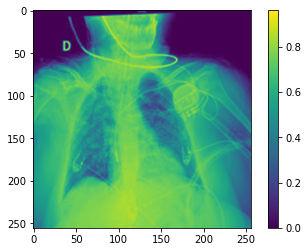

In [9]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

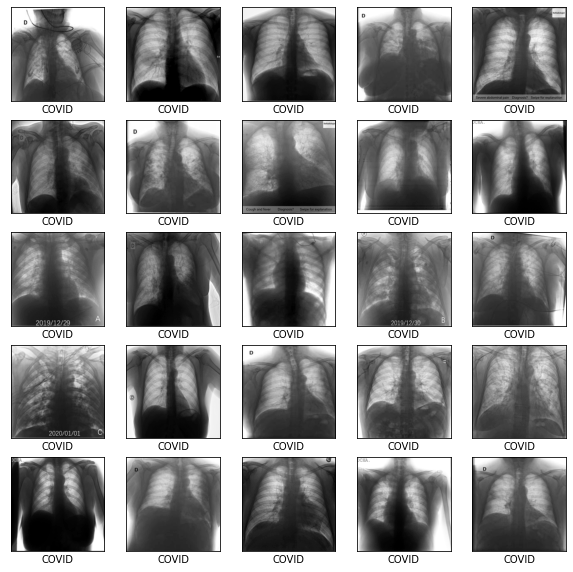

In [10]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(classes[y_train_classes[i]])
plt.show()

# Modelle aufbauen

### Methoden zur Analyse

In [11]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# early stopping values
callback_stop = tf.keras.callbacks.EarlyStopping(
    monitor="precision_m",
    min_delta=0.0003,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

### Modelle

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

data_dims = (256, 256, 1)

model_7 = Sequential([
    Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same", input_shape=data_dims),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.30),
    Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.30),
    Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.30),
    Flatten(),
    Dense(16, activation="sigmoid"),
    Dropout(0.25),
    Dense(4, activation="softmax")
])

model_7.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", "categorical_crossentropy", f1_m, precision_m, recall_m])

In [13]:
model = model_7

In [14]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 20)      200       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 20)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 20)      3620      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 20)        3620      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 20)       

## Modell trainieren und dabei Metriken aufzeichnen
**Accuracy und Loss**

Falls ``logs`` Ordner aus früherem Lauf vorhanden, diesen löschen...

In [15]:
from shutil import rmtree
if os.path.exists("logs"):
    rmtree("logs")

In [16]:
# sample weights
#print(y_train_classes)
print(len(y_train_classes))

s_weights = []
for i in y_train_classes:
    if y_train_classes[i] == 0:
        s_weights.append(1)
    if y_train_classes[i] == 1:
        s_weights.append(.7)
    if y_train_classes[i] == 2:
        s_weights.append(1)
    if y_train_classes[i] == 3:
        s_weights.append(1)



        
s_weights = np.array(s_weights)
s_weights.shape
print(s_weights)

#class weights
c_weights = {
   0: .40, 
   1: .1, 
   2: .25, 
   3: .25
}

15558
[1 1 1 ... 1 1 1]


In [17]:
from sklearn.utils import class_weight

log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
print(X_train.shape)

model.fit(
    X_train.reshape(-1, 256, 256, 1), y_train,
    epochs=10,
    batch_size=100,
    #shuffle=True,
    #class_weight=c_weights,
    #sample_weight=s_weights,
    validation_data=(X_test.reshape(-1, 256, 256, 1), y_test),
    #callbacks=[callback_stop],
    verbose=1
    )

(15558, 256, 256, 1)
Epoch 1/10
156/156 [==============================] - 250s 2s/step - loss: 1.0972 - accuracy: 0.5187 - categorical_crossentropy: 1.0972 - f1_m: 0.4672 - precision_m: 0.7213 - recall_m: 0.3502 - val_loss: 0.9969 - val_accuracy: 0.5247 - val_categorical_crossentropy: 0.9969 - val_f1_m: 0.4384 - val_precision_m: 0.5355 - val_recall_m: 0.3780
Epoch 2/10
156/156 [==============================] - 244s 2s/step - loss: 0.9515 - accuracy: 0.5566 - categorical_crossentropy: 0.9515 - f1_m: 0.5411 - precision_m: 0.8189 - recall_m: 0.4063 - val_loss: 0.7810 - val_accuracy: 0.6878 - val_categorical_crossentropy: 0.7810 - val_f1_m: 0.4868 - val_precision_m: 0.5327 - val_recall_m: 0.4525
Epoch 3/10
156/156 [==============================] - 246s 2s/step - loss: 0.7056 - accuracy: 0.7157 - categorical_crossentropy: 0.7056 - f1_m: 0.6490 - precision_m: 0.8321 - recall_m: 0.5366 - val_loss: 0.5693 - val_accuracy: 0.7973 - val_categorical_crossentropy: 0.5693 - val_f1_m: 0.7251 - val

In [19]:
y_test_pred = model.predict(X_test.reshape(-1, 256, 256, 1))
y_test_pred_classes = tf.argmax(y_test_pred, axis=1)

In [20]:
y_test_pred

array([[9.6744519e-01, 2.7641995e-02, 9.4529882e-04, 3.9673778e-03],
       [9.4455677e-01, 4.6247084e-02, 1.6677028e-03, 7.5283968e-03],
       [9.6274984e-01, 3.2474071e-02, 9.2374586e-04, 3.8523839e-03],
       ...,
       [3.6548097e-02, 1.7021237e-01, 5.1996088e-01, 2.7327865e-01],
       [9.8716805e-04, 6.4286934e-03, 1.9207682e-01, 8.0050731e-01],
       [6.8252431e-03, 9.2996880e-03, 6.9966084e-01, 2.8421429e-01]],
      dtype=float32)

In [21]:
y_test_pred_classes

<tf.Tensor: shape=(1944,), dtype=int64, numpy=array([0, 0, 0, ..., 2, 3, 2], dtype=int64)>

## Metriken und Analyse

### Prediction Accuracy

In [22]:
def plot_image(i, pred_array, true_label, img):
    pred_array, true_label, img = pred_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    pred_label = np.argmax(pred_array)
    if pred_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classes[pred_label],
                                  100*np.max(pred_array),
                                  classes[true_label]),
                                  color=color)

def plot_value_array(i, pred_array, true_label):
    pred_array, true_label = pred_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(4))
    plt.yticks([])
    thisplot = plt.bar(range(4), pred_array, color="#777777")
    plt.ylim([0, 1])
    pred_label = np.argmax(pred_array)

    thisplot[pred_label].set_color('red')
    thisplot[true_label].set_color('blue')

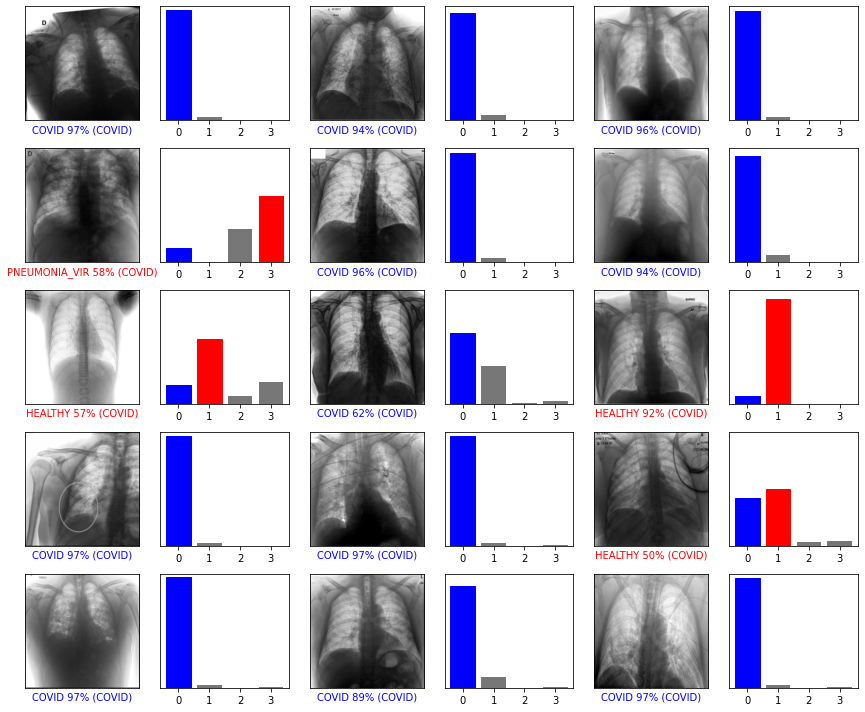

In [23]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_test_pred[i], y_test_classes, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_test_pred[i], y_test_classes)
plt.tight_layout()
plt.show()

### Confusion Matrix

In [24]:
cm = tf.math.confusion_matrix(y_test_classes, y_test_pred_classes).numpy()
#cm

In [25]:
import pandas as pd
import seaborn

def plot_confusion_matrix(cm):
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)
    figure = plt.figure(figsize=(8, 8))
    seaborn.heatmap(cm_df, annot=True, fmt="g", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    #figure.savefig('cm_model.svg', format='svg')
    return figure

In [26]:
cm_norm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)
#cm_norm

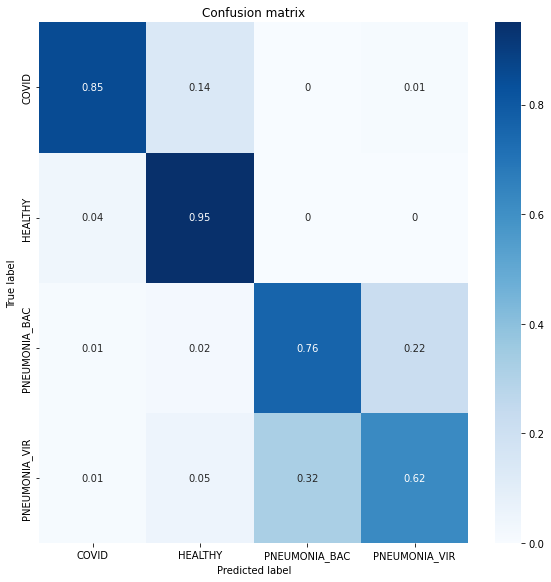

In [27]:
figure = plot_confusion_matrix(cm_norm)

### PR Curve (Average)

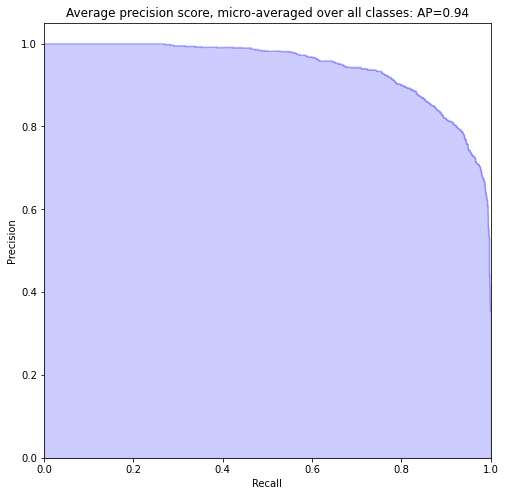

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from inspect import signature

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_test_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_test_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_test_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, y_test_pred, average="micro")

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

fig = plt.figure(figsize=(8, 8))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2, where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))

plt.show()

#fig.savefig('mnist-precision-recall.svg', format='svg')

### PR Curve

In [1]:
from itertools import cycle

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(4), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(classes[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision recall curve (multi-class)')
plt.legend(lines, labels, prop=dict(size=4))

plt.show()

fig.savefig('mnist-precision-recall-extended.svg', format='svg')

NameError: name 'plt' is not defined

### ROC Curve

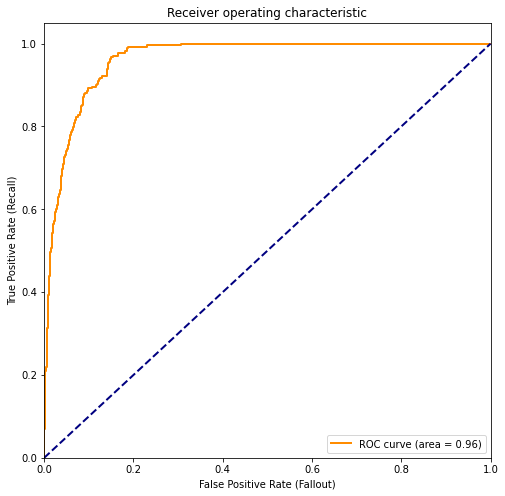

In [30]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

fig = plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Fallout)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

#fig.savefig('mnist-roc.svg', format='svg')

## Modell analysieren

In [31]:
model.layers
weights = model.layers[0].weights[0].numpy()
weights

array([[[[-7.96316639e-02, -1.50649130e-01, -1.78795122e-03,
          -2.22015351e-01,  1.23565786e-01, -1.94013104e-01,
           8.13589469e-02,  5.81515115e-03, -8.73433873e-02,
          -1.07570641e-01, -4.62962203e-02, -7.28781670e-02,
           1.49999693e-01, -9.72305425e-03,  5.26698269e-02,
          -1.26361549e-01, -5.36441505e-02,  1.40616000e-01,
           2.28033558e-01,  5.50841838e-02]],

        [[ 1.20826818e-01,  1.41084611e-01,  8.90124664e-02,
           2.19237819e-01,  1.03256620e-01, -1.50113538e-01,
          -1.93199843e-01,  7.62079060e-02, -1.11007012e-01,
          -5.18989861e-02, -2.76836809e-02,  6.94915876e-02,
          -1.00674510e-01, -6.13106638e-02, -1.47400752e-01,
          -1.16095714e-01,  2.64162640e-03, -1.21147878e-01,
           2.29168944e-02, -1.74347654e-01]],

        [[ 2.19116290e-03,  2.03571811e-01, -5.73422238e-02,
           1.95173189e-01, -6.09059818e-02,  2.26997972e-01,
           9.28223017e-07, -5.40611483e-02,  1.64046

In [32]:
weights[:, :, :, 0].reshape(3, 3)

array([[-0.07963166,  0.12082682,  0.00219116],
       [ 0.17773673,  0.00231331,  0.03112603],
       [ 0.0215722 ,  0.10083222, -0.00882366]], dtype=float32)

In [33]:
#plt.imshow(weights[:, :, :, 0].reshape(3, 3))
#plt.show()

### Filter der Convolution-Schicht

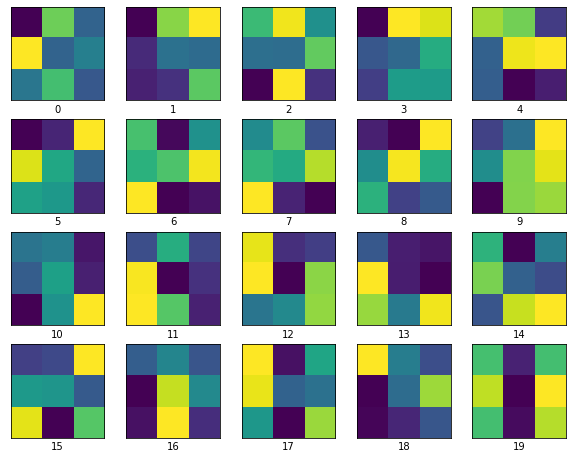

In [34]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(weights[:, :, :, i].reshape(3, 3))
    plt.xlabel(i)
plt.show()

In [35]:
model_l1 = Sequential()

model_l1.add(Conv2D(20,
                   kernel_size=(3, 3),
                   activation="relu",
                   input_shape=(64, 64, 1),
                   weights=model.layers[0].get_weights()))
model_l1.add(Conv2D(20,
                   kernel_size=(3, 3),
                   activation="relu",
                   weights=model.layers[2].get_weights()))

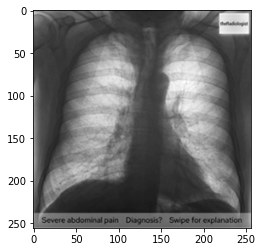

(1, 252, 252, 20)

In [38]:
img_nbr = 4

plt.imshow(X_train[img_nbr], cmap=plt.cm.binary)
plt.show()
result = model_l1.predict(X_train[img_nbr].reshape(1, 256, 256, 1))
result.shape

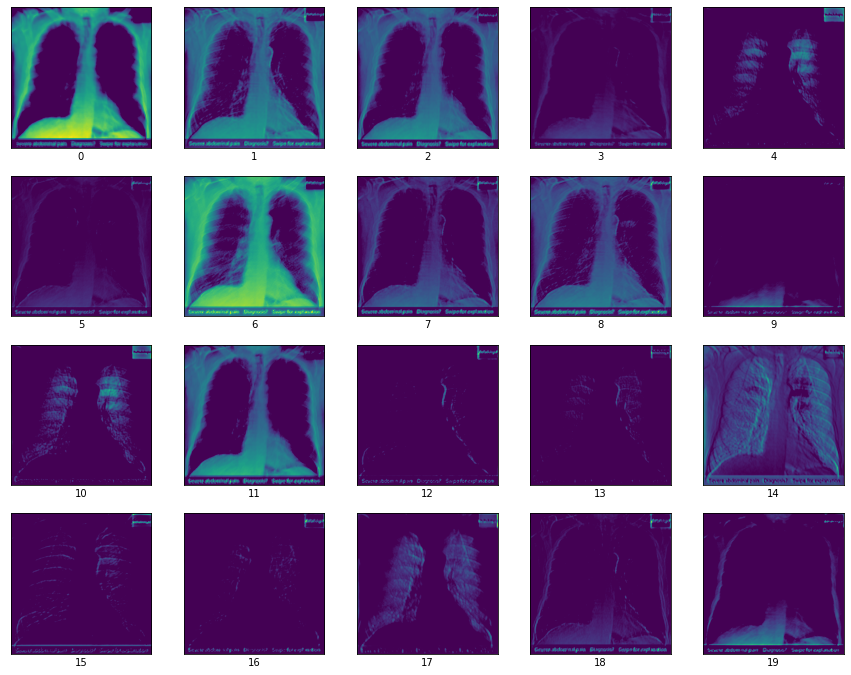

In [39]:
plt.figure(figsize=(15, 15))
for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(result[0, :, :, i])
    plt.xlabel(i)
plt.show()

### Examples for all classes

In [ ]:
y_test_pred_l1 = model_l1.predict(X_test.reshape(-1, 256, 256, 1))
y_test_pred_l1.shape

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(25, 11, (i*11+1))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    for j in range(20):
        plt.subplot(25, 11, (i*11+1)+(j+1))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(y_test_pred_l1[i, :, :, j])
#plt.show()